In [0]:
!git clone -b dev https://github.com/nyikovicsmate/thesis

Cloning into 'thesis'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 1567 (delta 98), reused 111 (delta 72), pack-reused 1419
Receiving objects: 100% (1567/1567), 163.36 MiB | 13.89 MiB/s, done.
Resolving deltas: 100% (587/587), done.


In [0]:
%cd thesis

/content/thesis


In [0]:
!pip3 install -q gdown
# bsd500_gray.zip
!gdown https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
!unzip -q bsd500_gray.zip
# # bsd500_color.zip
!gdown https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
!unzip -q bsd500_color.zip
# # set14_color.zip
!gdown https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
!unzip -q set14_color.zip

Downloading...
From: https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
To: /content/thesis/bsd500_gray.zip
11.3MB [00:00, 21.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
To: /content/thesis/bsd500_color.zip
29.4MB [00:01, 28.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
To: /content/thesis/set14_color.zip
100% 831k/831k [00:00<00:00, 55.4MB/s]


In [0]:
%tensorflow_version 2.x
from src.networks.supervised.pre_upsampling_network import PreUpsamplingNetwork
from src.callbacks import *
from src.dataset import *
import numpy as np
import tensorflow as tf

In [0]:
batch_size = 20
seed = 1111
epochs = 5000
learning_rate = 1e-6

normalize = lambda x: np.array(x / 255.0, dtype=np.float32)
downsample = lambda x: np.array([cv2.resize(x_i, (x.shape[2]//2, x.shape[1]//2), interpolation=cv2.INTER_CUBIC) for x_i in x])
ds_hr = HDFDataset("bsd500_70_70_color.h5")\
    .batch(batch_size)\
    .shuffle(seed=seed)\
    .map(normalize)\
    .transform()
ds_lr = HDFDataset("bsd500_70_70_color.h5")\
    .batch(batch_size)\
    .shuffle(seed=seed)\
    .map(downsample)\
    .map(normalize)\
    .transform()

input_shape = (None, None, 3)
loss_func = tf.keras.losses.mse
cb = [TrainingCheckpointCallback(appendix="_color", save_freq=20),
       ExponentialDecayCallback(learning_rate, epochs/5, decay_rate=0.8)]

In [0]:
network = PreUpsamplingNetwork(input_shape=input_shape)
network.train(ds_lr, ds_hr, loss_func, epochs, learning_rate, cb)

Streaming output truncated to the last 5000 lines.
[2020-05-20 11:48:51,347] INFO save_state(): Saved state.
[2020-05-20 11:48:52,479] INFO _train(): Epoch: 400 train_loss: 23840.88
[2020-05-20 11:48:53,620] INFO _train(): Epoch: 401 train_loss: 23763.29
[2020-05-20 11:48:54,758] INFO _train(): Epoch: 402 train_loss: 23763.34
[2020-05-20 11:48:55,893] INFO _train(): Epoch: 403 train_loss: 23738.03
[2020-05-20 11:48:57,028] INFO _train(): Epoch: 404 train_loss: 23702.89
[2020-05-20 11:48:58,165] INFO _train(): Epoch: 405 train_loss: 23673.34
[2020-05-20 11:48:59,294] INFO _train(): Epoch: 406 train_loss: 23650.67
[2020-05-20 11:49:00,423] INFO _train(): Epoch: 407 train_loss: 23606.32
[2020-05-20 11:49:01,554] INFO _train(): Epoch: 408 train_loss: 23595.82
[2020-05-20 11:49:02,688] INFO _train(): Epoch: 409 train_loss: 23562.68
[2020-05-20 11:49:03,821] INFO _train(): Epoch: 410 train_loss: 23538.08
[2020-05-20 11:49:04,943] INFO _train(): Epoch: 411 train_loss: 23482.11
[2020-05-20 11:

[2020-05-20 13:15:35,206] INFO load_state(): Loaded state with: 
Train time: 01h:29m:49s
Epochs:     4940
Loss:       16146.0498
[2020-05-20 13:15:35,243] INFO _parse_predict_optionals(): Predicting using the default upsampling factor of 2.
[2020-05-20 13:15:35,411] INFO _predict(): Predicted images with shape: (14, 70, 70, 3)
   HR   ALIASED   NETWORK   


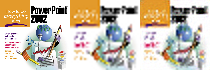

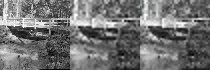

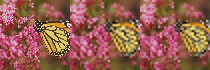

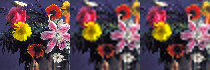

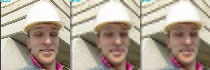

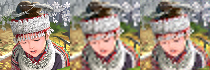

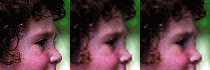

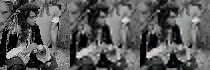

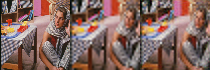

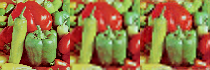

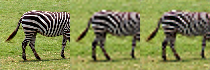

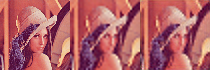

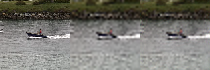

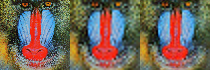

SSIM
max: [4] 0.87    min: [10] 0.60    avg: 0.70
TOTAL_VARIATION
max: [5] 1970.63    min: [6] 816.32    avg: 1495.92
PSNR
max: [6] 27.49    min: [0] 15.94    avg: 20.70
MEAN_SQUARED_ERROR
max: [0] 124.77    min: [6] 8.74    avg: 50.30
MEAN_ABSOLUTE_ERROR
max: [0] 447.24    min: [6] 141.37    avg: 318.72


In [0]:
from google.colab.patches import cv2_imshow

ds_ev_lr = DirectoryDataset("set14_70_70_color")\
    .map(downsample)\
    .map(normalize)
ds_ev_hr = DirectoryDataset("set14_70_70_color")\
    .map(normalize)

# load best network state
network.load_state("_color")

with ds_ev_lr as x, ds_ev_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

[2020-05-20 13:16:16,668] INFO _parse_predict_optionals(): Predicting using the default upsampling factor of 2.
[2020-05-20 13:16:16,865] INFO _predict(): Predicted images with shape: (10, 70, 70, 3)
   HR   ALIASED   NETWORK   


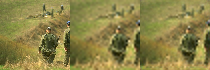

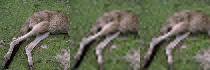

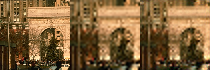

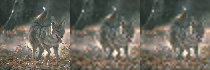

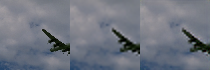

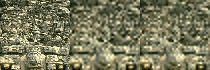

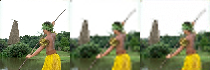

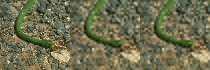

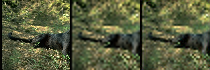

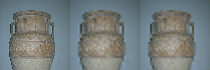

SSIM
max: [4] 0.95    min: [5] 0.54    avg: 0.70
TOTAL_VARIATION
max: [5] 2190.62    min: [4] 394.95    avg: 1135.65
PSNR
max: [4] 32.50    min: [5] 16.22    avg: 23.41
MEAN_SQUARED_ERROR
max: [5] 117.00    min: [4] 2.75    avg: 34.89
MEAN_ABSOLUTE_ERROR
max: [5] 588.85    min: [4] 47.24    avg: 261.08


In [0]:
# PREDICT WITH THE TRAINING DATASET

ds = HDFDataset("bsd500_70_70_color.h5").batch(10)
ds_hr = ds.map(normalize)
ds_lr = ds.map(downsample).map(normalize)

with ds_lr as x, ds_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

In [0]:
!zip -r ./preupsamplingnetwork_color.zip ./checkpoints/preupsamplingnetwork_color

  adding: checkpoints/preupsamplingnetwork_color/ (stored 0%)
  adding: checkpoints/preupsamplingnetwork_color/checkpoint (deflated 37%)
  adding: checkpoints/preupsamplingnetwork_color/weights.data-00000-of-00002 (deflated 70%)
  adding: checkpoints/preupsamplingnetwork_color/weights.data-00001-of-00002 (deflated 7%)
  adding: checkpoints/preupsamplingnetwork_color/weights.index (deflated 54%)
  adding: checkpoints/preupsamplingnetwork_color/state.dat (deflated 15%)


In [0]:
from google.colab.files import download

download("preupsamplingnetwork_color.zip")